In [26]:
# %%capture
# if 'google.colab' in str(get_ipython()):
#     !pip install

In [48]:
import ee
# import geemap.core as geemap  # in colab
import geemap
import eerepr
import geopandas as gpd
import matplotlib.pyplot as plt

In [28]:
cloud_project = 'ee-hadicu06indo' # replace with your project id

ee.Authenticate()
ee.Initialize(project=cloud_project)

# FeatureCollection to Pandas DataFrame and GeoPandas GeoDataFrame

In [29]:
country = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level1") \
    .filter(ee.Filter.eq('ADM0_NAME', 'Indonesia'))
java_filter = ee.Filter.stringContains('ADM1_NAME', 'Jawa')
sel_provs = country.filter(java_filter)

terra_climate = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE') \
    .filterBounds(sel_provs)

tmax = terra_climate.select('tmmx')

def calculate_yearly_mean_tmax_by_region(year):
    year = ee.Number(year)
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = start_date.advance(1, 'year')

    filtered = tmax.filterDate(start_date, end_date)
    reduced = filtered.reduce(ee.Reducer.mean())

    def compute_mean(feature):
        region_mean = reduced.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=feature.geometry(),
            scale=5000,
            maxPixels=1e10
        )
        return ee.Feature(
            feature.geometry(),
            region_mean.set('regionName', feature.get('ADM1_NAME'))
                       .set('year', year.format('%d'))
        )

    return sel_provs.map(compute_mean)

years = ee.List.sequence(2000, 2023)
results = years.map(calculate_yearly_mean_tmax_by_region)
results_fc = ee.FeatureCollection(results).flatten()


In [30]:
%%time
results_fc.limit(3)

CPU times: user 58 µs, sys: 5 µs, total: 63 µs
Wall time: 67 µs


## Using geemap package

In [31]:
%%time
results_df_geemap = geemap.ee_to_df(results_fc)

CPU times: user 35.3 ms, sys: 1.75 ms, total: 37.1 ms
Wall time: 5.56 s


In [32]:
display(type(results_df_geemap))
results_df_geemap.head()

pandas.core.frame.DataFrame

,regionName,tmmx_mean,year
0,Jawa Barat,289.492101,2000
1,Jawa Tengah,300.695600,2000
2,Jawa Timur,298.588232,2000
3,Jawa Barat,286.980593,2001
4,Jawa Tengah,298.801753,2001


In [33]:
results_df_geemap.to_csv('results_df_geemap.csv', index=False)

In [34]:
%%time
results_gdf_geemap = geemap.ee_to_gdf(results_fc)

CPU times: user 798 ms, sys: 52.4 ms, total: 850 ms
Wall time: 14.6 s


In [35]:
display(type(results_gdf_geemap))
results_gdf_geemap.head()

geopandas.geodataframe.GeoDataFrame

,geometry,regionName,tmmx_mean,year
0,GEOMETRYCOLLECTION (LINESTRING (106.85081 -6.3...,Jawa Barat,289.492101,2000
1,GEOMETRYCOLLECTION (LINESTRING (108.55983 -7.3...,Jawa Tengah,300.695600,2000
2,GEOMETRYCOLLECTION (LINESTRING (111.06834 -8.0...,Jawa Timur,298.588232,2000
3,GEOMETRYCOLLECTION (LINESTRING (106.85081 -6.3...,Jawa Barat,286.980593,2001
4,GEOMETRYCOLLECTION (LINESTRING (108.55983 -7.3...,Jawa Tengah,298.801753,2001


In [36]:
results_gdf_geemap.to_file("results_gdf_geemap.gpkg", driver="GPKG")

## Using EE Python API (ee.data.computeFeatures)

In [37]:
%%time
results_df_computeFeatures = ee.data.computeFeatures({
    'expression': results_fc,
    'fileFormat': 'PANDAS_DATAFRAME'
})

CPU times: user 612 ms, sys: 37.8 ms, total: 650 ms
Wall time: 14.2 s


In [38]:
display(type(results_df_computeFeatures))
results_df_computeFeatures.head()

pandas.core.frame.DataFrame

,geo,regionName,tmmx_mean,year
0,"{'type': 'GeometryCollection', 'geometries': [...",Jawa Barat,289.492101,2000
1,"{'type': 'GeometryCollection', 'geometries': [...",Jawa Tengah,300.695600,2000
2,"{'type': 'GeometryCollection', 'geometries': [...",Jawa Timur,298.588232,2000
3,"{'type': 'GeometryCollection', 'geometries': [...",Jawa Barat,286.980593,2001
4,"{'type': 'GeometryCollection', 'geometries': [...",Jawa Tengah,298.801753,2001


In [45]:
results_df_computeFeatures = results_df_computeFeatures.drop(columns=['geo'])

In [46]:
results_df_computeFeatures.to_csv('results_df_computeFeatures.csv', index=False)

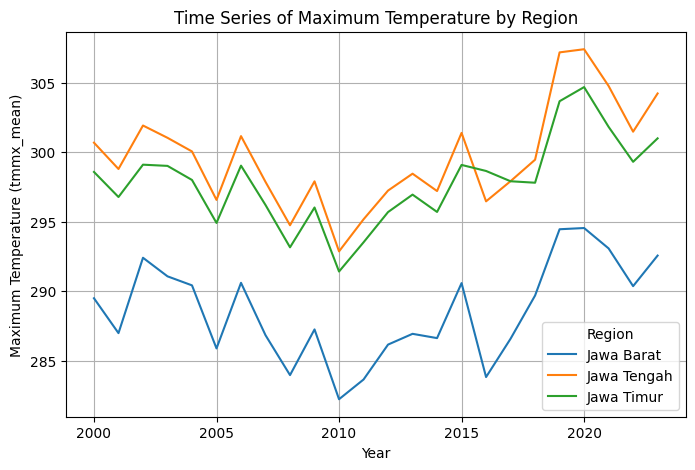

In [52]:
results_df_computeFeatures['year'] = results_df_computeFeatures['year'].astype(int)

regions = results_df_computeFeatures['regionName'].unique()

fig, ax = plt.subplots(figsize=(8, 5))  # Create figure and axis

for region in regions:
    region_data = results_df_computeFeatures[results_df_computeFeatures['regionName'] == region]
    ax.plot(region_data['year'], region_data['tmmx_mean'], label=region)

ax.set_xlabel('Year')
ax.set_ylabel('Maximum Temperature (tmmx_mean)')
ax.set_title('Time Series of Maximum Temperature by Region')
ax.legend(title='Region')
ax.grid(True)

plt.show()

In [40]:
%%time
results_gdf_computeFeatures = ee.data.computeFeatures({
    'expression': results_fc,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

CPU times: user 795 ms, sys: 58.6 ms, total: 853 ms
Wall time: 11.2 s


In [41]:
display(type(results_gdf_computeFeatures))
results_gdf_computeFeatures.head()

geopandas.geodataframe.GeoDataFrame

,geometry,regionName,tmmx_mean,year
0,GEOMETRYCOLLECTION (LINESTRING (106.85081 -6.3...,Jawa Barat,289.492101,2000
1,GEOMETRYCOLLECTION (LINESTRING (108.55983 -7.3...,Jawa Tengah,300.695600,2000
2,GEOMETRYCOLLECTION (LINESTRING (111.06834 -8.0...,Jawa Timur,298.588232,2000
3,GEOMETRYCOLLECTION (LINESTRING (106.85081 -6.3...,Jawa Barat,286.980593,2001
4,GEOMETRYCOLLECTION (LINESTRING (108.55983 -7.3...,Jawa Tengah,298.801753,2001


In [42]:
results_gdf_computeFeatures.crs = 'EPSG:4326'

In [43]:
results_gdf_computeFeatures.to_file("results_gdf_computeFeatures.gpkg", driver="GPKG")